# Sign-Language MNIST

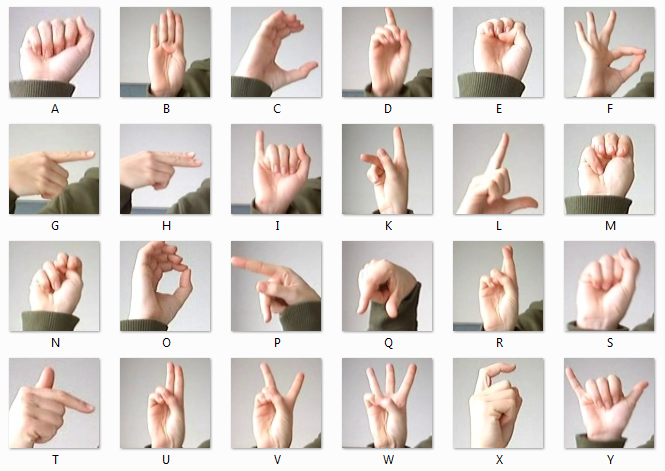

In [1]:
from tensorflow import keras
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [4]:
! pip install opencv-python==4.6.0.66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading the ASL dataset

In [7]:
from google.colab import files
 
 
uploaded = files.upload()

Saving amer_sign2.png to amer_sign2.png
Saving amer_sign3.png to amer_sign3.png
Saving american_sign_language.PNG to american_sign_language.PNG
Saving sign_mnist_test.csv to sign_mnist_test.csv
Saving sign_mnist_train.csv to sign_mnist_train.csv


In [9]:

import pandas as pd
import io
 
train_df = pd.read_csv(io.BytesIO(uploaded["sign_mnist_train.csv"]))
test_df = pd.read_csv(io.BytesIO(uploaded["sign_mnist_test.csv"]))

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# Data Visualization and Preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


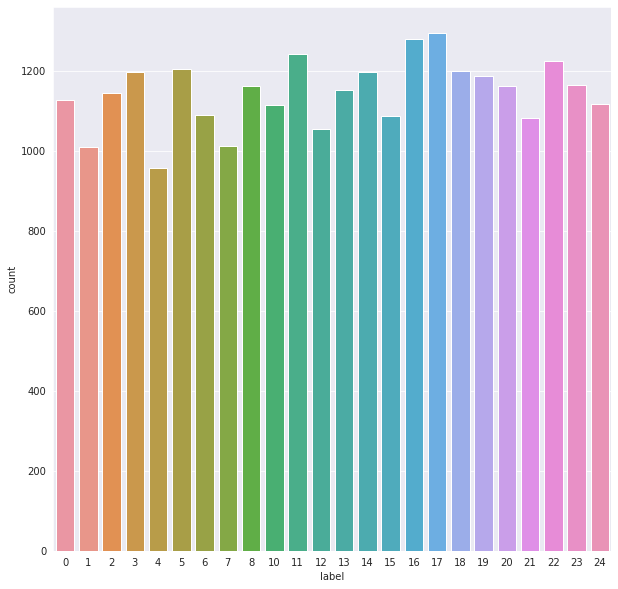

In [11]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])


In [12]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [13]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [14]:
x_train = train_df.values
x_test = test_df.values

### We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [15]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [16]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

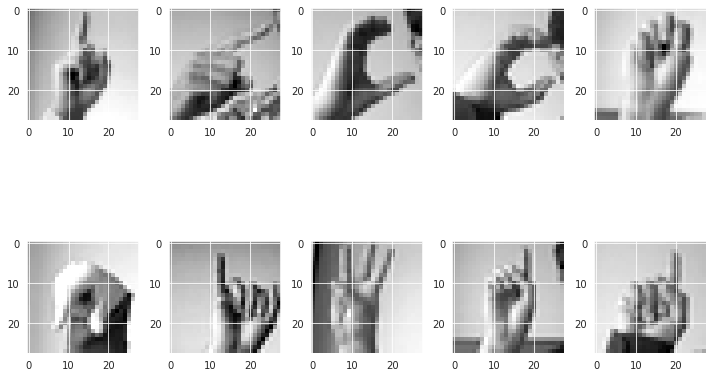

In [17]:
# Preview of first 10 images
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()  

# Data Augmentation #1

In [18]:
datagen_1 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=False,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=False,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=False,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_1.fit(x_train)

# Training the first simple model

In [19]:
model_1 = Sequential()

#model_1.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
#model_1.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))

model_1.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',input_shape=(28,28,1)))
model_1.add(MaxPool2D((2,2),2,padding='same'))

model_1.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
model_1.add(MaxPool2D((2,2),2,padding='same'))

model_1.add(Flatten())

model_1.add(Dense(units=120, activation='relu'))
model_1.add(Dense(units=24, activation = 'softmax'))

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [20]:
model_1.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [21]:
history_1 = model_1.fit(datagen_1.flow(x_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (x_test, y_test))

Epoch 1/20
215/215 [==============================] - 12s 11ms/step - loss: 1.8174 - accuracy: 0.4777 - val_loss: 0.8888 - val_accuracy: 0.7409
Epoch 2/20
215/215 [==============================] - 3s 13ms/step - loss: 0.4091 - accuracy: 0.8756 - val_loss: 0.6233 - val_accuracy: 0.7980
Epoch 3/20
215/215 [==============================] - 2s 11ms/step - loss: 0.1564 - accuracy: 0.9588 - val_loss: 0.6048 - val_accuracy: 0.8274
Epoch 4/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0628 - accuracy: 0.9883 - val_loss: 0.5897 - val_accuracy: 0.8472
Epoch 5/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0311 - accuracy: 0.9959 - val_loss: 0.6087 - val_accuracy: 0.8515
Epoch 6/20
215/215 [==============================] - 2s 10ms/step - loss: 0.0167 - accuracy: 0.9986 - val_loss: 0.6696 - val_accuracy: 0.8498
Epoch 7/20
215/215 [==============================] - 2s 9ms/step - loss: 0.0084 - accuracy: 0.9996 - val_loss: 0.7261 - val_accuracy: 0.8522


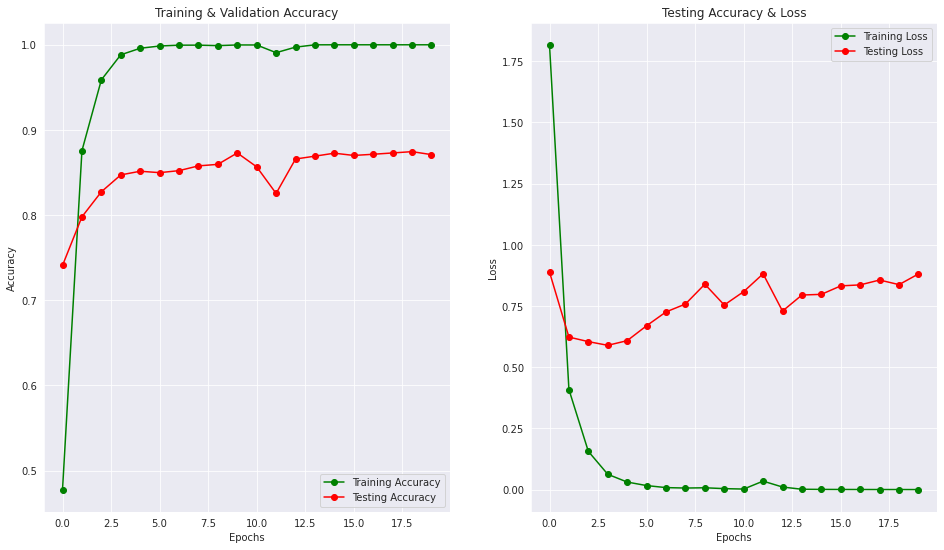

In [22]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_1.history['accuracy']
train_loss = history_1.history['loss']
val_acc = history_1.history['val_accuracy']
val_loss = history_1.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [23]:
metrics=pd.DataFrame(history_1.history)
metrics['epoch']=history_1.epoch
metrics

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.817425,0.477654,0.888840,0.740937,0
1,0.409105,0.875615,0.623304,0.797964,1
2,0.156413,0.958842,0.604777,0.827384,2
3,0.062812,0.988272,0.589679,0.847183,3
4,0.031067,0.995921,0.608682,0.851506,4
5,0.016688,0.998580,0.669584,0.849833,5
6,0.008371,0.999563,0.726104,0.852203,6
7,0.006612,0.999599,0.758354,0.857780,7
8,0.007675,0.999017,0.839378,0.859593,8
9,0.004208,0.999818,0.754343,0.872978,9


# Model 2 -- dropout 0.25

In [24]:
model_2 = Sequential()

model_2.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model_2.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))

model_2.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu', padding='same'))
model_2.add(MaxPool2D((2,2),2,padding='same'))

model_2.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
model_2.add(MaxPool2D((2,2),2,padding='same'))

model_2.add(Flatten())

model_2.add(Dense(units=120, activation='relu'))
model_2.add(Dropout(rate=0.25))  # dropout
model_2.add(Dense(units=24, activation = 'softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        32832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 32)        

In [25]:
model_2.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

history_2 = model_2.fit(datagen_1.flow(x_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (x_test, y_test))

Epoch 1/20
215/215 [==============================] - 4s 16ms/step - loss: 2.0431 - accuracy: 0.3642 - val_loss: 0.9409 - val_accuracy: 0.6732
Epoch 2/20
215/215 [==============================] - 3s 14ms/step - loss: 0.5368 - accuracy: 0.8185 - val_loss: 0.5093 - val_accuracy: 0.8314
Epoch 3/20
215/215 [==============================] - 3s 15ms/step - loss: 0.2086 - accuracy: 0.9299 - val_loss: 0.4368 - val_accuracy: 0.8719
Epoch 4/20
215/215 [==============================] - 3s 14ms/step - loss: 0.1110 - accuracy: 0.9655 - val_loss: 0.3141 - val_accuracy: 0.9229
Epoch 5/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0628 - accuracy: 0.9807 - val_loss: 0.3175 - val_accuracy: 0.9228
Epoch 6/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0424 - accuracy: 0.9870 - val_loss: 0.3080 - val_accuracy: 0.9262
Epoch 7/20
215/215 [==============================] - 3s 14ms/step - loss: 0.0371 - accuracy: 0.9878 - val_loss: 0.3194 - val_accuracy: 0.9141

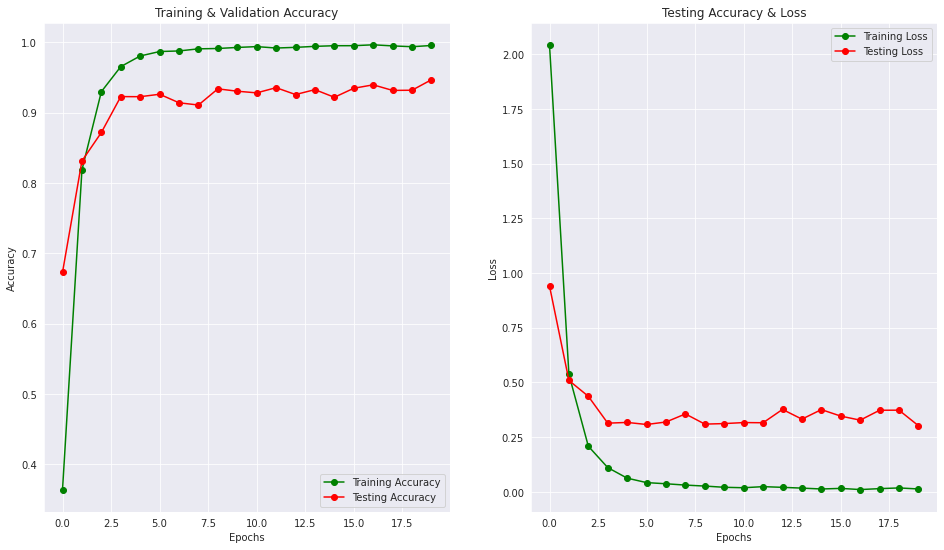

In [26]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_2.history['accuracy']
train_loss = history_2.history['loss']
val_acc = history_2.history['val_accuracy']
val_loss = history_2.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [27]:
metrics=pd.DataFrame(history_2.history)
metrics['epoch']=history_2.epoch
metrics

,loss,accuracy,val_loss,val_accuracy,epoch
0,2.043085,0.364232,0.940861,0.673173,0
1,0.536811,0.818539,0.509263,0.831428,1
2,0.208640,0.929922,0.436814,0.871863,2
3,0.111037,0.965507,0.314091,0.922895,3
4,0.062764,0.980659,0.317461,0.922755,4
5,0.042445,0.986960,0.308005,0.926241,5
6,0.037136,0.987798,0.319439,0.914110,6
7,0.031091,0.990785,0.356279,0.910904,7
8,0.026643,0.991295,0.309738,0.933910,8
9,0.021054,0.992788,0.312147,0.930563,9


# Model 3 -- dropout , BatchNormalization

In [28]:
model_3 = Sequential()

model_3.add(Conv2D(128,kernel_size=(3,3), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

model_3.add(Conv2D(64,kernel_size=(3,3), strides=1,activation='relu', padding='same'))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2),2,padding='same'))

model_3.add(Conv2D(32,kernel_size=(3,3), strides=1,activation='relu',padding='same'))
model_3.add(MaxPool2D((2,2),2,padding='same'))

model_3.add(Flatten())

model_3.add(Dense(units=120, activation='relu'))
model_3.add(Dropout(rate=0.25))  # dropout
model_3.add(Dense(units=24, activation = 'softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)      

In [29]:
model_3.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

history_3 = model_3.fit(datagen_1.flow(x_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (x_test, y_test))

Epoch 1/20
215/215 [==============================] - 8s 31ms/step - loss: 0.9418 - accuracy: 0.7156 - val_loss: 3.7891 - val_accuracy: 0.0608
Epoch 2/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0658 - accuracy: 0.9815 - val_loss: 1.7217 - val_accuracy: 0.5092
Epoch 3/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0259 - accuracy: 0.9936 - val_loss: 0.2379 - val_accuracy: 0.9313
Epoch 4/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.1459 - val_accuracy: 0.9492
Epoch 5/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.2172 - val_accuracy: 0.9285
Epoch 6/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.1423 - val_accuracy: 0.9578
Epoch 7/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.2747 - val_accuracy: 0.9219

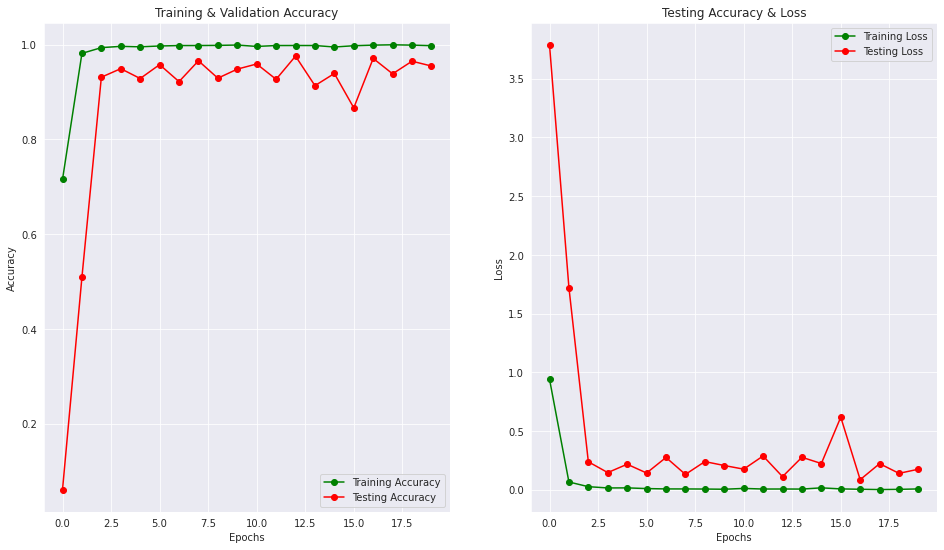

In [30]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_3.history['accuracy']
train_loss = history_3.history['loss']
val_acc = history_3.history['val_accuracy']
val_loss = history_3.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [31]:
metrics=pd.DataFrame(history_3.history)
metrics['epoch']=history_3.epoch
metrics

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.941792,0.715571,3.789107,0.060792,0
1,0.065843,0.981533,1.721684,0.509202,1
2,0.025909,0.993626,0.237884,0.931260,2
3,0.015094,0.996358,0.145913,0.949247,3
4,0.015688,0.995411,0.217162,0.928472,4
5,0.009809,0.997123,0.142306,0.957752,5
6,0.006800,0.998033,0.274684,0.921919,6
7,0.006657,0.998070,0.130397,0.965839,7
8,0.005827,0.998397,0.239539,0.929169,8
9,0.004049,0.999126,0.206162,0.948271,9


# Model 4 -- dropout, BatchNormalization, callbacks, dense (512)

In [32]:
callbacks = [EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001, verbose=1, monitor='val_accuracy'),
    ]


In [33]:
model_4 = Sequential()

model_4.add(Conv2D(128,kernel_size=(3,3), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

model_4.add(Conv2D(64,kernel_size=(3,3), strides=1,activation='relu', padding='same'))
model_4.add(Dropout(0.2))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D((2,2),2,padding='same'))

model_4.add(Conv2D(32,kernel_size=(3,3), strides=1,activation='relu',padding='same'))
model_4.add(MaxPool2D((2,2),2,padding='same'))

model_4.add(Flatten())

model_4.add(Dense(units=512, activation='relu'))
model_4.add(Dropout(rate=0.25))  # dropout
model_4.add(Dense(units=24, activation = 'softmax'))

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)      

In [34]:
model_4.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

history_4 = model_4.fit(datagen_1.flow(x_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (x_test, y_test), 
                    callbacks = [callbacks])


Epoch 1/20
215/215 [==============================] - 8s 31ms/step - loss: 0.6367 - accuracy: 0.8125 - val_loss: 4.1275 - val_accuracy: 0.1166 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 5s 25ms/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 1.9659 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 0.2791 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 4s 17ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.5405 - val_accuracy: 0.8494 - lr: 0.0010
Epoch 5/20
212/215 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9972
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 4s 17ms/step - loss: 0.0104 - accuracy: 0.9972 - val_loss: 0.3305 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 4s 18

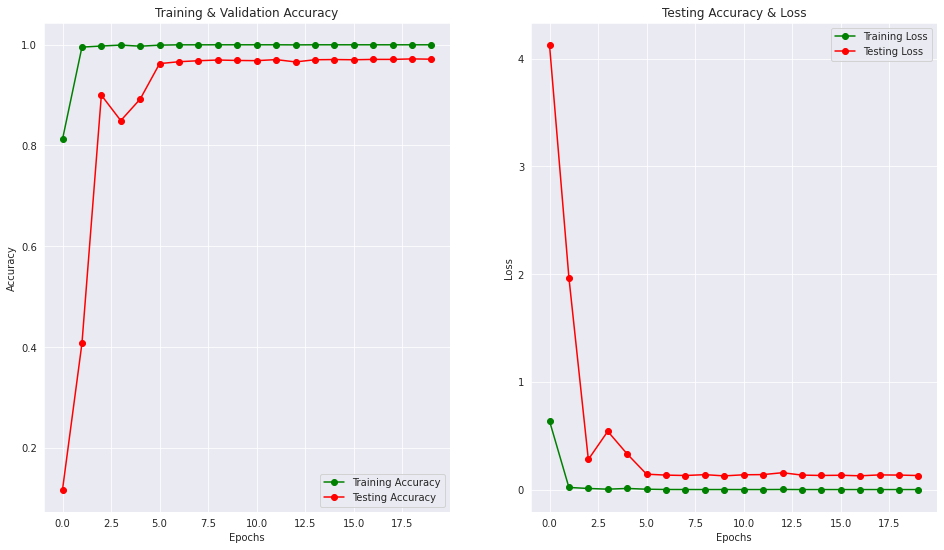

In [36]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_4.history['accuracy']
train_loss = history_4.history['loss']
val_acc = history_4.history['val_accuracy']
val_loss = history_4.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Training The Final Model 

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

In [37]:
datagen_2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_2.fit(x_train)

In [38]:
model_5 = Sequential()

model_5.add(Conv2D(128,kernel_size=(3,3), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

model_5.add(Conv2D(64,kernel_size=(3,3), strides=1,activation='relu', padding='same'))
model_5.add(Dropout(0.2))
model_5.add(BatchNormalization())
model_5.add(MaxPool2D((2,2),2,padding='same'))

model_5.add(Conv2D(32,kernel_size=(3,3), strides=1,activation='relu',padding='same'))
model_5.add(MaxPool2D((2,2),2,padding='same'))

model_5.add(Flatten())

model_5.add(Dense(units=512, activation='relu'))
model_5.add(Dropout(rate=0.25))  # dropout
model_5.add(Dense(units=24, activation = 'softmax'))

model_5.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 64)      

In [39]:
model_5.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

history_5 = model_5.fit(datagen_2.flow(x_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (x_test, y_test), 
                    callbacks = [callbacks])

Epoch 1/20
215/215 [==============================] - 10s 43ms/step - loss: 1.0841 - accuracy: 0.6601 - val_loss: 6.1492 - val_accuracy: 0.0569 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 9s 42ms/step - loss: 0.1965 - accuracy: 0.9352 - val_loss: 2.7890 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 8s 39ms/step - loss: 0.0942 - accuracy: 0.9696 - val_loss: 0.0929 - val_accuracy: 0.9749 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 9s 42ms/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.0334 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 10s 46ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 0.1734 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.9881
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 8s 

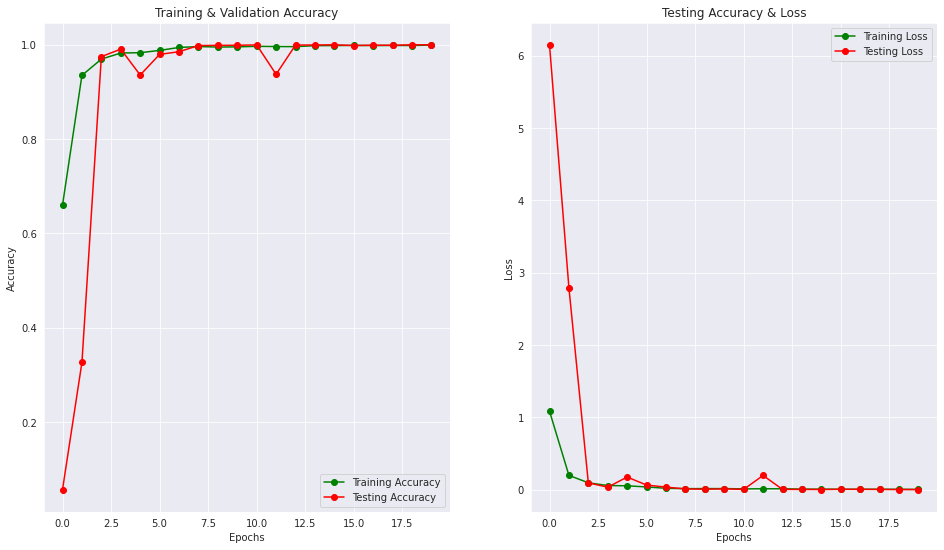

In [40]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history_5.history['accuracy']
train_loss = history_5.history['loss']
val_acc = history_5.history['val_accuracy']
val_loss = history_5.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()